# 线性神经网络

## 线性回归

### 线性回归的基本元素

#### 基本概念

自变量x和因变量y之间的关系是线性的，且观测值存在的噪音服从正态分布。

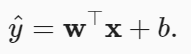

要想寻找最好的模型参数w和b， 需要两个东西： 

（1）一种模型质量的度量方式：损失函数； 

（2）一种能够更新模型以提高模型预测质量的方法：优化方法；

#### 损失函数

对于单个样本，误差为：

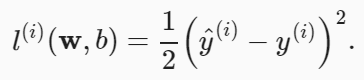

在整个训练集 n 个样本上的损失均值为：

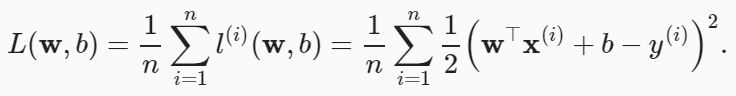

最优参数为能最小化所有训练样本上的总损失：

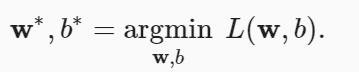

#### 优化方法

对于线性模型来说，线性回归的解可以用一个公式简单地表达出来， 这类解叫作解析解。

很多情况下，我们没有办法得到解析解。在无法得到解析解的情况下，我们仍然需要有效地训练模型。 

梯度下降（gradient descent）法几乎可以优化所有深度学习模型。 它通过不断地在损失函数递减的方向上更新参数来降低误差。

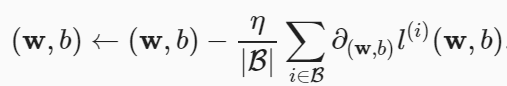

上述是小批量随机梯度下降更新参数的公式。

### 矢量化加速

训练模型时，通常希望能够同时处理整个小批量数据，通过矢量化利用线性代数库计算，而不是python中的for循环，可以大大提高计算效率。

In [1]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

In [2]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

In [3]:
class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

In [4]:
# for循环，每次执行一位加法
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.07158 sec'

In [5]:
# 重载加号运算符来按元素求和
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00000 sec'

结果很明显，第二种方法比第一种方法快得多。 矢量化代码通常会带来数量级的加速。 

### 正态分布与平方损失

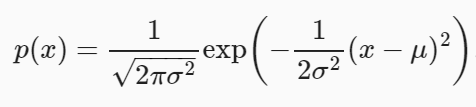

In [6]:
# 定义正态分布概率密度函数
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

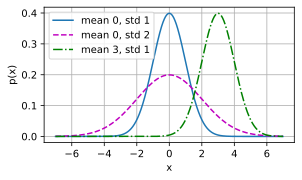

In [7]:
# 再次使用numpy进行可视化
x = np.arange(-7, 7, 0.01)

# 均值和标准差对
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

> 在高斯噪声的假设下，最小化均方误差等价于对线性模型的极大似然估计。

均方误差损失函数（简称均方损失）可以用于线性回归的一个原因是： 我们假设了观测中包含噪声，其中噪声服从正态分布。 噪声正态分布如下式:

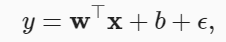

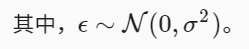

我们现在可以写出通过给定的 x 观测到特定 y 的似然:


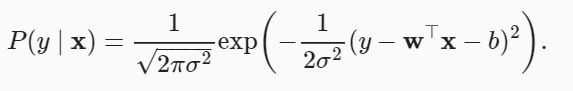

根据极大似然估计法，参数 w 和 b 的最优值是使整个数据集的似然最大的值：

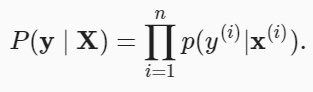

改写成求最小化负对数似然:

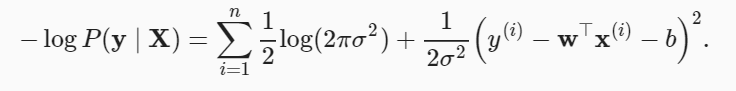

现在我们只需要假设 σ 是某个固定常数就可以忽略第一项， 因为第一项不依赖于 w 和 b 。 现在第二项除了常数 1σ2 外，其余部分和前面介绍的均方误差是一样的。 幸运的是，上面式子的解并不依赖于 σ 。 因此，在高斯噪声的假设下，最小化均方误差等价于对线性模型的极大似然估计。

### 从线性回归到神经网络 

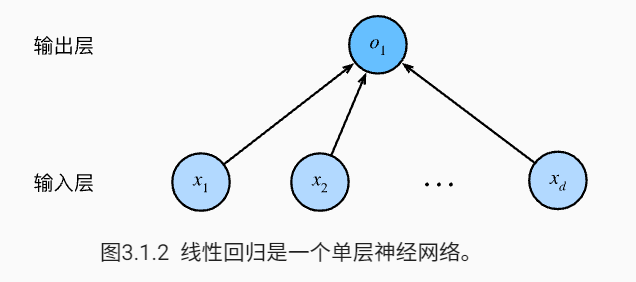

## 线性回归从零开始实现

In [8]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

### 生成数据集 

In [9]:
def synthetic_data(w,b,num_examples): #@save
    X = torch.normal(0,1,(num_examples,len(w)))
    y = torch.matmul(X,w) + b
    y += torch.normal(0,0.01,y.shape)
    return X,y.reshape((-1,1))

true_w = torch.tensor([2,-3.4])
true_b = 4.2
features,labels = synthetic_data(true_w,true_b,1000)

In [10]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([1.3877, 0.7781]) 
label: tensor([4.3232])


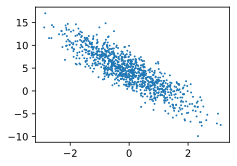

In [11]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);

### 读取数据集

我们定义一个data_iter函数， 该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量。 每个小批量包含一组特征和标签。

In [12]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

GPU可以在处理几百个样本时，所花费的时间不比处理一个样本时多太多。

In [13]:
batch_size = 10
for X,y in data_iter(batch_size,features,labels):
    print(X,'\n',y)
    break

tensor([[ 0.4886,  1.4332],
        [ 0.6250, -1.1102],
        [ 0.0836, -0.1837],
        [ 2.1922,  0.0328],
        [ 0.5461, -0.8496],
        [-1.7126,  0.2563],
        [-1.7123, -0.0983],
        [ 0.6438, -0.9304],
        [ 2.1986, -0.5167],
        [-2.2257, -0.8417]]) 
 tensor([[ 0.3173],
        [ 9.2281],
        [ 4.9853],
        [ 8.4790],
        [ 8.1655],
        [-0.1107],
        [ 1.1143],
        [ 8.6468],
        [10.3365],
        [ 2.6197]])


上述手写的迭代器效率有点低，因为它要求我们将所有数据加载到内存中，并执行大量的随机内存访问。 在深度学习框架中实现的内置迭代器效率要高得多， 它可以处理存储在文件中的数据和数据流提供的数据。

### 初始化模型参数

In [26]:
w = torch.normal(0,0.01,size=(2,1),requires_grad=True)
b = torch.zeros(1,requires_grad=True)

### 定义模型

In [15]:
def linreg(X,w,b): #@save
    return torch.matmul(X,w) + b

### 定义损失 

In [16]:
def squared_loss(y_hat,y): #@save
    return (y_hat-y.reshape(y_hat.shape))**2 / 2

### 定义优化函数

In [17]:
def sgd(params,lr,batch_size): #@save
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 训练 

每次迭代，取小批量样本数据，通过模型获得一组预测。计算损失，然后通过反向传播，获得各参数的梯度。通过优化算法来更新模型参数，得到新的模型。不断重复这个过程。

In [27]:
lr = 0.03
num_epochs = 3
# batch_size = 21

for epoch in range(num_epochs):
    # 每次epoch遍历整个数据集
    for X,y in data_iter(batch_size, features, labels):
        loss = squared_loss(linreg(X,w,b),y)
        loss.sum().backward() # 反向传播，自动微分
        sgd([w,b],lr,batch_size)
    with torch.no_grad(): # 从求梯度的计算图中剥离出来
        train_loss = squared_loss(linreg(features,w,b),labels)
        print(f'epoch {epoch + 1},loss {train_loss.mean():.5f}')

epoch 1,loss 0.75715
epoch 2,loss 0.03292
epoch 3,loss 0.00154


### 练习 

1、初始权重设置为0，会怎样？

https://zhuanlan.zhihu.com/p/75879624

2、如果样本个数不能被批量大小整除，data_iter函数的行为会有什么变化？

最后一个batch要是很小，可能会影响效率？

要么设置为整除；要么不要最后一个batch；要么补充为一整个batch

## 线性回归的简洁实现

### 生成数据集 

In [28]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

### 读取数据集 

In [29]:
def load_array(data_arrays,batch_size,is_train=True):
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays) # ? 转换为tensor结构
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [30]:
# 我们使用iter构造Python迭代器，并使用next从迭代器中获取第一项。
next(iter(data_iter))

[tensor([[ 0.8537, -0.3442],
         [ 0.9521,  2.2967],
         [-1.3637, -1.3422],
         [-0.5032,  0.6407],
         [ 1.1523, -1.0792],
         [-0.8504,  0.0504],
         [-1.1393, -2.2537],
         [-0.1838,  1.8611],
         [ 1.6524, -1.3350],
         [-3.1888,  0.2292]]),
 tensor([[ 7.0741],
         [-1.7000],
         [ 6.0325],
         [ 1.0097],
         [10.1653],
         [ 2.3253],
         [ 9.5725],
         [-2.4798],
         [12.0586],
         [-2.9537]])]

### 定义模型 

In [31]:
from torch import nn

# 第一个指定输入特征形状，即2，第二个指定输出特征形状，输出特征形状为单个标量，因此为1。
net = nn.Sequential(nn.Linear(2,1))

### 初始化模型参数 

通过net[0]选择网络中的第一个图层， 然后使用weight.data和bias.data方法访问参数。 我们还可以使用替换方法normal_和fill_来重写参数值。

In [32]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

### 定义损失函数 

In [33]:
# 它返回所有样本损失的平均值。
loss = nn.MSELoss()

### 定义优化函数

In [35]:
# 要指定优化的参数以及优化算法所需的超参数字典
trainer = torch.optim.SGD(net.parameters(), lr=0.03) # lr/min_batch

### 训练 

通过调用net(X)生成预测并计算损失l（前向传播）。

通过进行反向传播来计算梯度。

通过调用优化器来更新模型参数。

In [36]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward() # 已经做了sum
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000172
epoch 2, loss 0.000102
epoch 3, loss 0.000103


In [37]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))

w的估计误差： tensor([-6.0558e-05,  9.6393e-04])


In [38]:
b = net[0].bias.data
print('b的估计误差：', true_b - b)

b的估计误差： tensor([5.9605e-05])
